Add Starting Pitching to Model

    In the last notebook we augmented our dataframe to include various features based on the starting pitcher's performance
    Now we will add these features in to see how much improvement we get to our model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
df = pd.read_csv('df_bp5.csv', low_memory=False)

BEGIN MODELING

In [3]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1970) & (df.season<=2010)]
df_valid = df[(df.season>=2011) & (df.season<=2020)]
df_test = df[df.season>=2021]

In [4]:
hv_mean = df_train.home_victory.mean()

FIRST -- Just add in ERA and WHIP over last 35 games (in addition to first model params)

In [5]:
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_35_h','Strt_ERA_35_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v', 
]
target = 'home_victory'

In [6]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [7]:
X_train.shape, X_valid.shape, X_test.shape

((86446, 8), (22758, 8), (4852, 8))

In [8]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.689679
[20]	valid_0's binary_logloss: 0.688735
[30]	valid_0's binary_logloss: 0.688015
[40]	valid_0's binary_logloss: 0.687415
[50]	valid_0's binary_logloss: 0.686954
[60]	valid_0's binary_logloss: 0.686538
[70]	valid_0's binary_logloss: 0.68614
[80]	valid_0's binary_logloss: 0.685799
[90]	valid_0's binary_logloss: 0.68546
[100]	valid_0's binary_logloss: 0.685127
[110]	valid_0's binary_logloss: 0.684829
[120]	valid_0's binary_logloss: 0.684551
[130]	valid_0's binary_logloss: 0.684315
[140]	valid_0's binary_logloss: 0.684105
[150]	valid_0's binary_logloss: 0.683961
[160]	valid_0's binary_logloss: 0.683814
[170]	valid_0's binary_logloss: 0.683679
[180]	valid_0's binary_logloss: 0.683562
[190]	valid_0's binary_logloss: 0.683431
[200]	valid_0's binary_logloss: 0.683323
[210]	valid_0's binary_logloss: 0.683225
[220]	valid_0's binary_logloss: 0.683137
[230]	valid_0's binary_logloss: 0.683075
[240]	v

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [9]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [10]:
# previous model gave 0.6851304948462116
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6746593621696388, 0.6905047445981213)

In [11]:
log_loss(y_test,df_test.implied_prob_h_mid)

0.6675629431340582

In [13]:
# naive-LV, naive-simp_mod, naive-current_mod

np.round([.6905 - .6674, .6905-.6851, .6905-.6747], decimals=4)

array([0.0231, 0.0054, 0.0158])

In [14]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

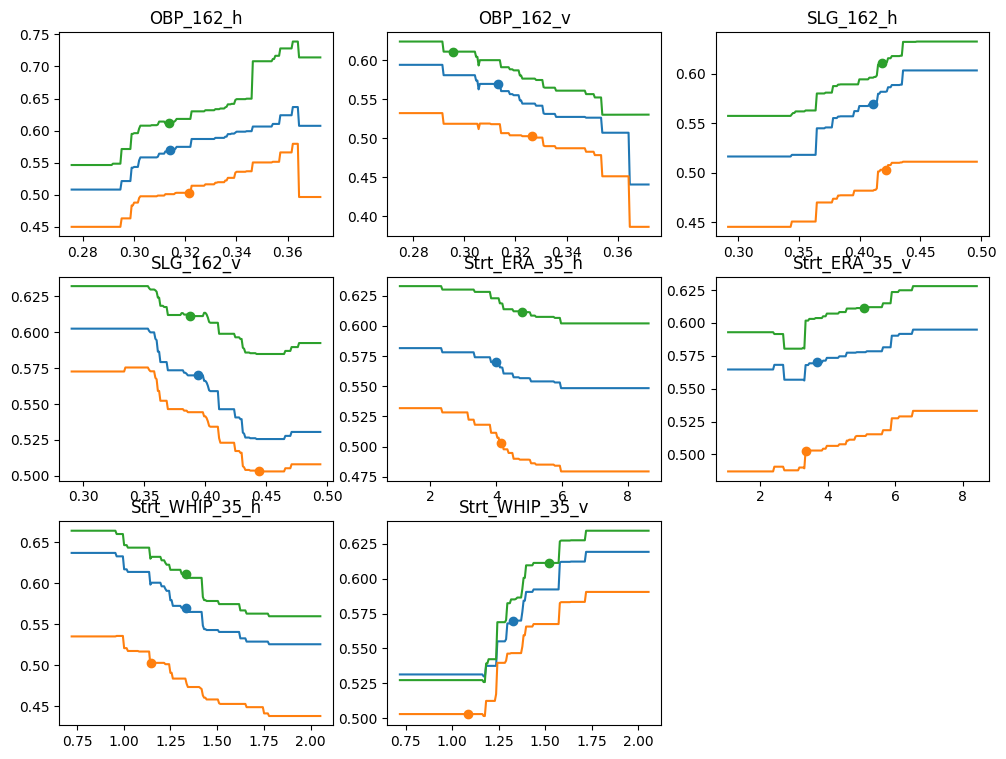

In [15]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

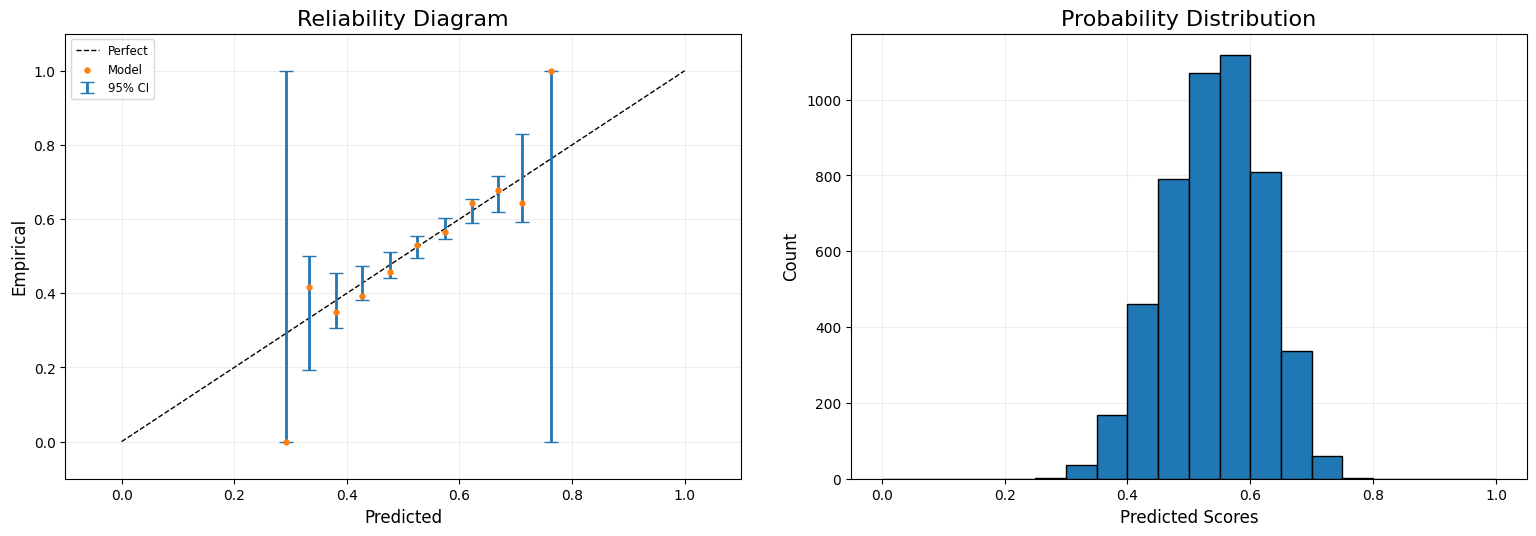

In [16]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [17]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [18]:
# This shows for each game, how the different features affected 

sv_lgbm.head(5).round(3)

,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,Strt_ERA_35_h,Strt_ERA_35_v,Strt_WHIP_35_h,Strt_WHIP_35_v,Intercept
0,-0.058,0.098,0.119,-0.006,0.039,0.010,0.206,0.074,0.162
1,-0.067,0.080,0.079,0.021,0.036,-0.076,0.124,-0.164,0.162
2,-0.005,0.016,0.122,-0.096,-0.047,-0.078,0.062,-0.166,0.162
3,-0.141,0.039,-0.022,-0.069,0.031,-0.073,0.039,-0.180,0.162
4,-0.043,0.024,0.055,-0.117,0.037,-0.010,0.130,-0.221,0.162


In [19]:
df_test.pitcher_start_name_v.iloc[2]

'Clayton Kershaw'

In [20]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept         0.161751
Strt_WHIP_35_h    0.102797
Strt_WHIP_35_v    0.096353
OBP_162_v         0.084720
OBP_162_h         0.082707
SLG_162_h         0.059186
SLG_162_v         0.054226
Strt_ERA_35_v     0.034963
Strt_ERA_35_h     0.034167
dtype: float64

Let's add in a few more pitching features...

In [21]:
# Add in SO% and "Modified Slugging Against"

features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_35_h','Strt_ERA_35_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_SO_perc_35_h', 'Strt_SO_perc_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
]
target = 'home_victory'

In [22]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [23]:
X_train.shape, X_valid.shape, X_test.shape

((86446, 14), (22758, 14), (4852, 14))

In [24]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.689632
[20]	valid_0's binary_logloss: 0.688663
[30]	valid_0's binary_logloss: 0.687949
[40]	valid_0's binary_logloss: 0.687346
[50]	valid_0's binary_logloss: 0.686904
[60]	valid_0's binary_logloss: 0.686487
[70]	valid_0's binary_logloss: 0.686062
[80]	valid_0's binary_logloss: 0.685686
[90]	valid_0's binary_logloss: 0.685338
[100]	valid_0's binary_logloss: 0.684985
[110]	valid_0's binary_logloss: 0.684634
[120]	valid_0's binary_logloss: 0.684342
[130]	valid_0's binary_logloss: 0.684074
[140]	valid_0's binary_logloss: 0.683821
[150]	valid_0's binary_logloss: 0.68361
[160]	valid_0's binary_logloss: 0.683423
[170]	valid_0's binary_logloss: 0.683181
[180]	valid_0's binary_logloss: 0.683057
[190]	valid_0's binary_logloss: 0.68289
[200]	valid_0's binary_logloss: 0.682784
[210]	valid_0's binary_logloss: 0.68268
[220]	valid_0's binary_logloss: 0.68257
[230]	valid_0's binary_logloss: 0.682454
[240]	val

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [25]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [26]:
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6748686764486739, 0.6905047445981213)

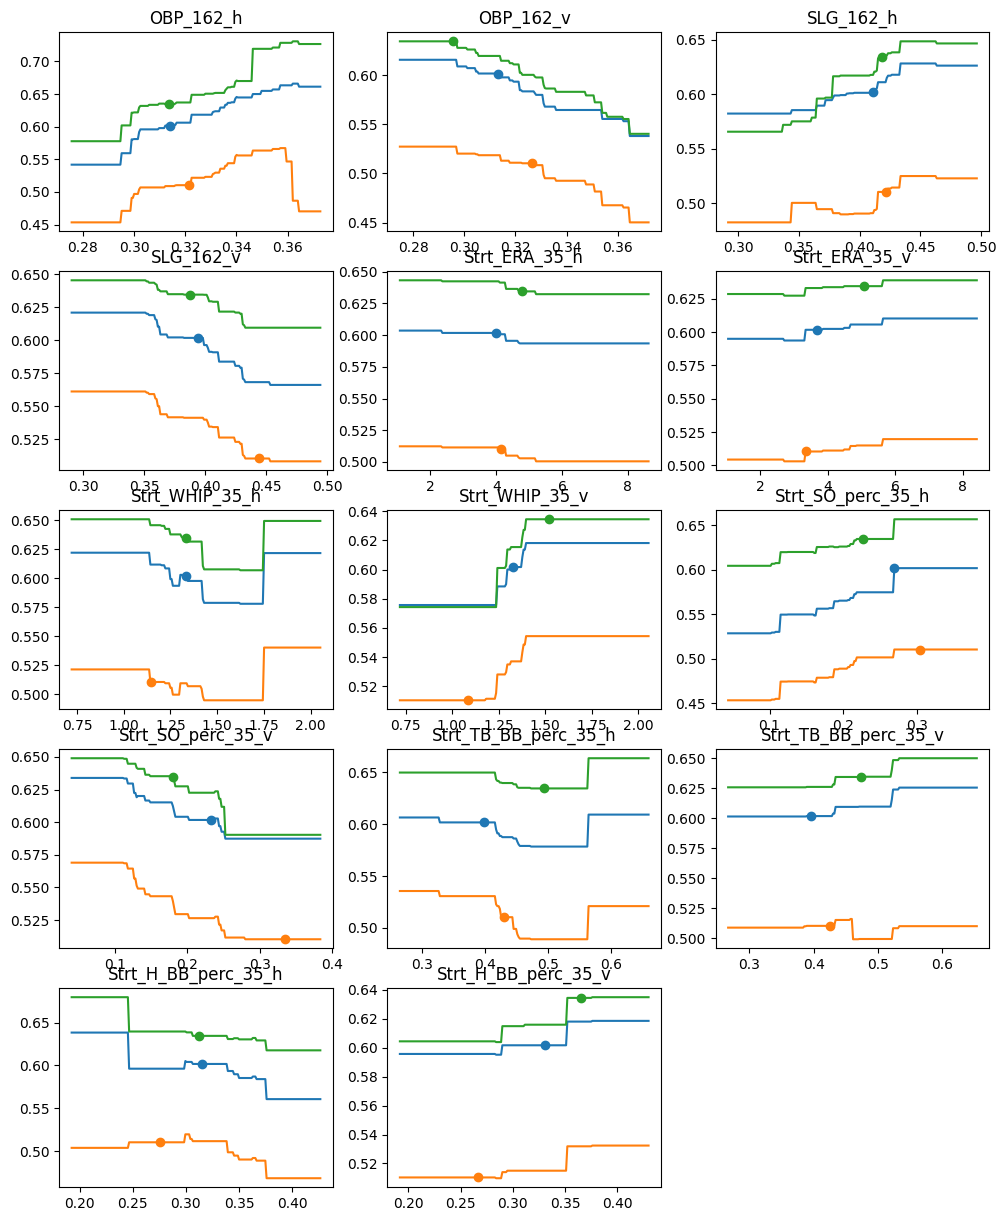

In [27]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

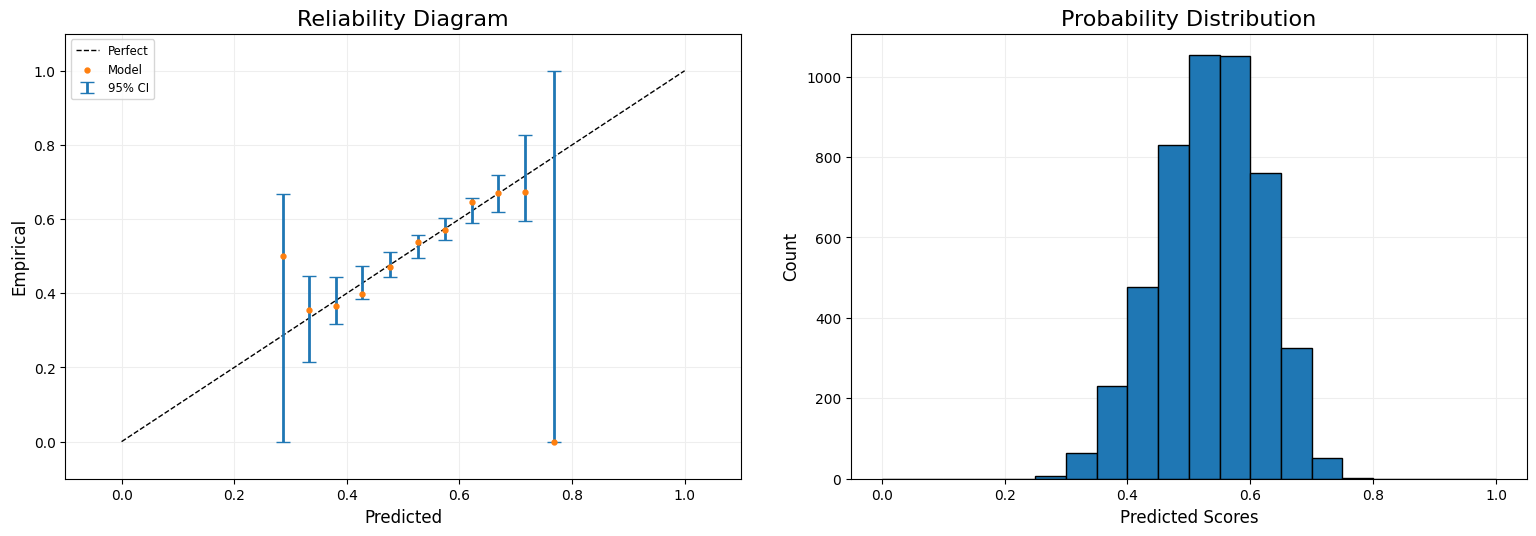

In [28]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [29]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [30]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.161713
OBP_162_h               0.089777
Strt_SO_perc_35_v       0.086374
OBP_162_v               0.079229
Strt_SO_perc_35_h       0.077506
Strt_WHIP_35_v          0.069228
Strt_WHIP_35_h          0.063841
SLG_162_h               0.048254
SLG_162_v               0.046670
Strt_TB_BB_perc_35_h    0.036940
Strt_H_BB_perc_35_h     0.026089
Strt_H_BB_perc_35_v     0.022171
Strt_ERA_35_v           0.019269
Strt_TB_BB_perc_35_v    0.017880
Strt_ERA_35_h           0.009036
dtype: float64

In [31]:
## Let's add in the 10 game lookback features
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_35_h','Strt_ERA_35_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_SO_perc_35_h', 'Strt_SO_perc_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_ERA_10_h','Strt_ERA_10_v',
            'Strt_WHIP_10_h','Strt_WHIP_10_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Strt_TB_BB_perc_10_h', 'Strt_TB_BB_perc_10_v',
]
target = 'home_victory'

In [32]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()


In [33]:
X_train.shape, X_valid.shape, X_test.shape

((86446, 20), (22758, 20), (4852, 20))

In [34]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.689633
[20]	valid_0's binary_logloss: 0.688674
[30]	valid_0's binary_logloss: 0.68794
[40]	valid_0's binary_logloss: 0.687385
[50]	valid_0's binary_logloss: 0.686893
[60]	valid_0's binary_logloss: 0.686445
[70]	valid_0's binary_logloss: 0.686078
[80]	valid_0's binary_logloss: 0.685726
[90]	valid_0's binary_logloss: 0.685367
[100]	valid_0's binary_logloss: 0.685077
[110]	valid_0's binary_logloss: 0.684796
[120]	valid_0's binary_logloss: 0.684508
[130]	valid_0's binary_logloss: 0.684226
[140]	valid_0's binary_logloss: 0.684038
[150]	valid_0's binary_logloss: 0.683865
[160]	valid_0's binary_logloss: 0.683623
[170]	valid_0's binary_logloss: 0.683487
[180]	valid_0's binary_logloss: 0.683304
[190]	valid_0's binary_logloss: 0.683133
[200]	valid_0's binary_logloss: 0.683012
[210]	valid_0's binary_logloss: 0.682841
[220]	valid_0's binary_logloss: 0.682739
[230]	valid_0's binary_logloss: 0.682557
[240]	

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [35]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [36]:
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6754240523139813, 0.6905047445981213)

In [37]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

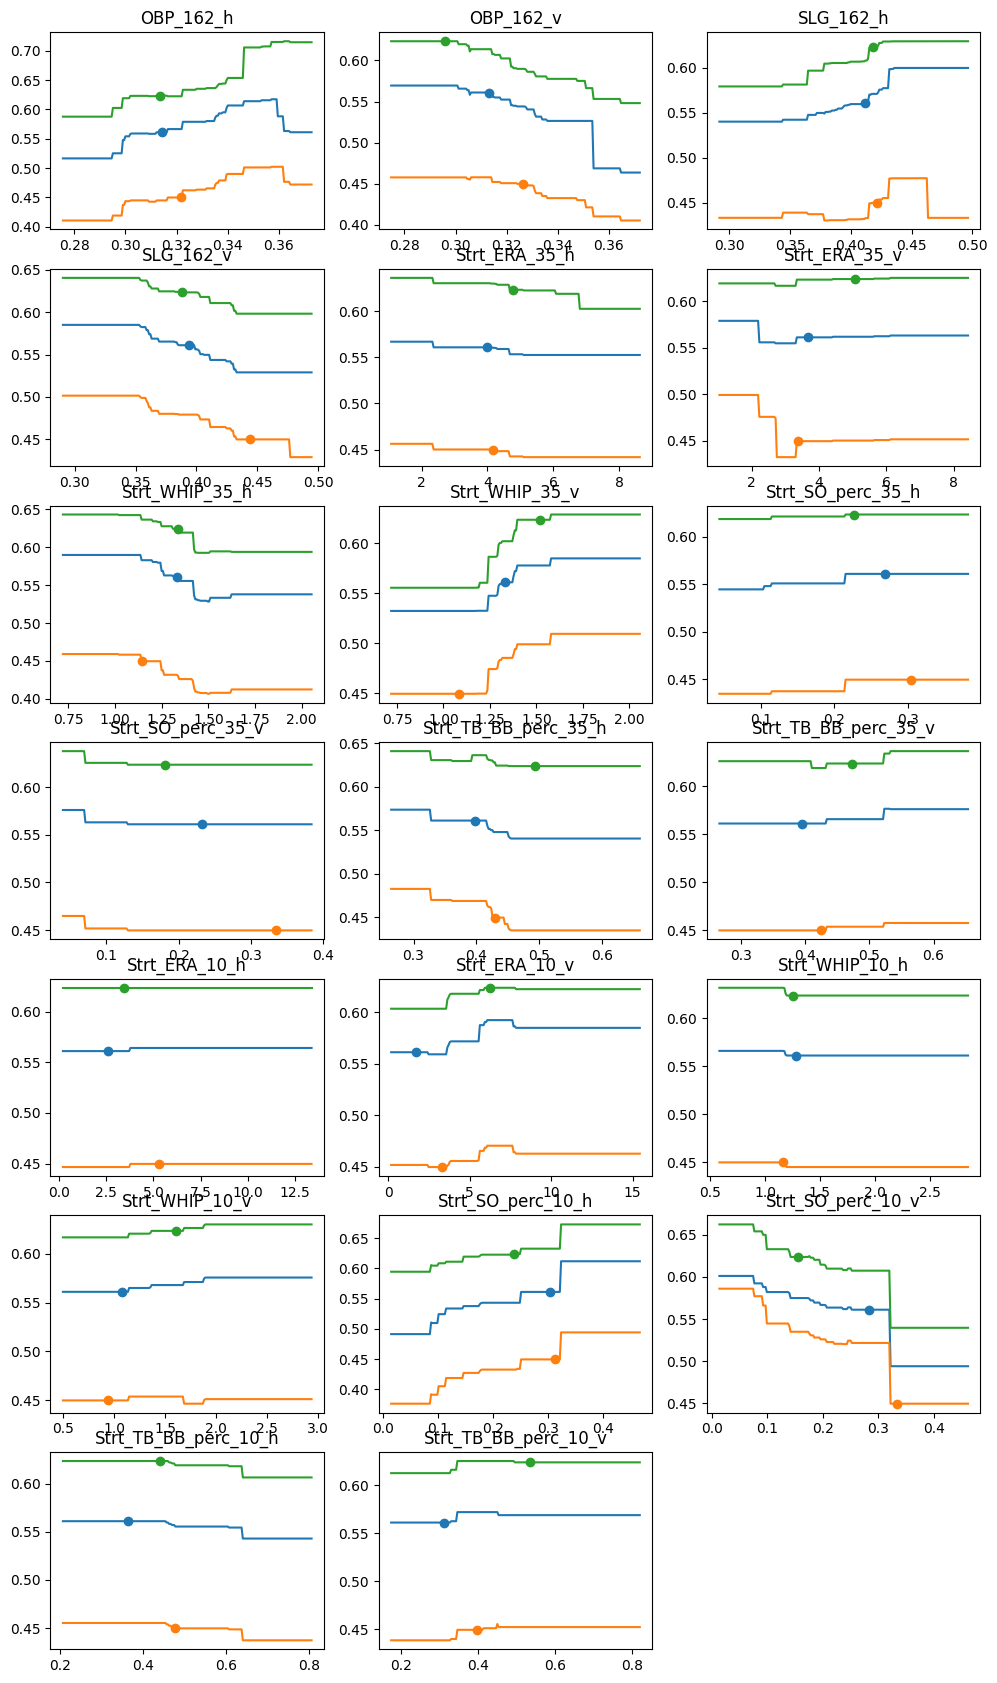

In [38]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

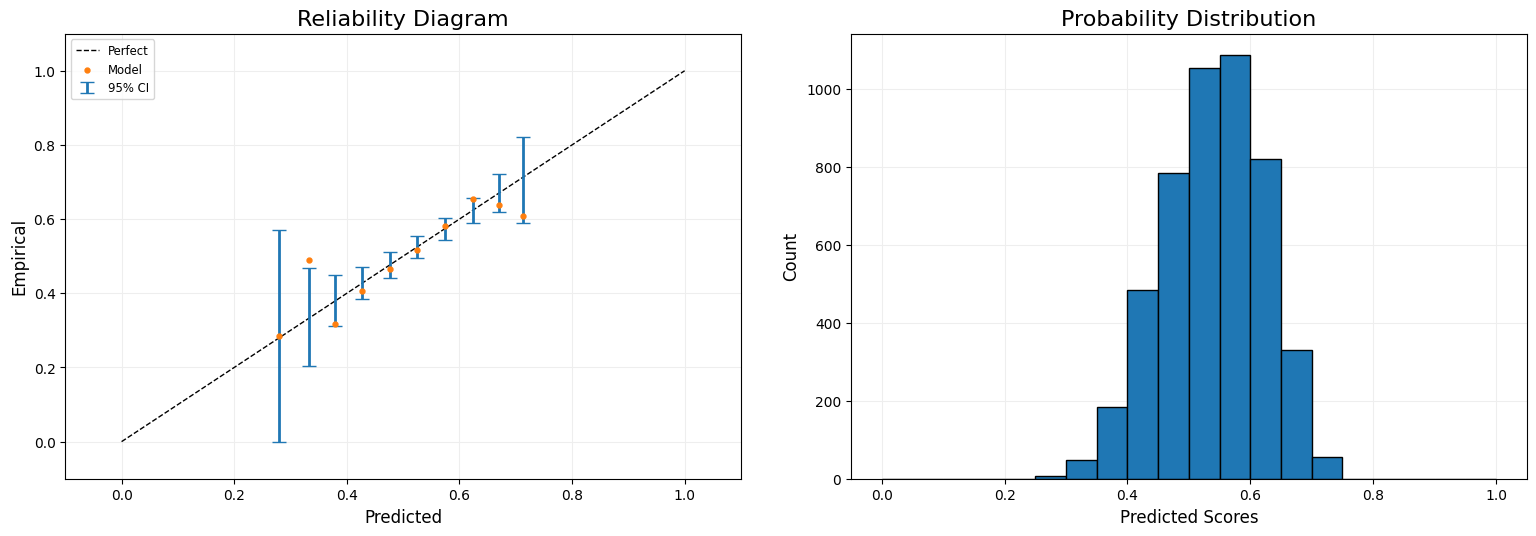

In [39]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [40]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [41]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.161802
Strt_SO_perc_10_v       0.082787
Strt_SO_perc_10_h       0.081909
OBP_162_h               0.079561
OBP_162_v               0.077206
Strt_WHIP_35_v          0.076788
Strt_WHIP_35_h          0.073948
SLG_162_h               0.048639
SLG_162_v               0.045226
Strt_TB_BB_perc_35_h    0.030317
Strt_ERA_10_v           0.022776
Strt_ERA_35_v           0.014231
Strt_ERA_35_h           0.012049
Strt_SO_perc_35_h       0.011984
Strt_WHIP_10_h          0.010512
Strt_TB_BB_perc_10_h    0.009924
Strt_TB_BB_perc_35_v    0.008979
Strt_TB_BB_perc_10_v    0.006734
Strt_WHIP_10_v          0.006428
Strt_SO_perc_35_v       0.003213
Strt_ERA_10_h           0.001240
dtype: float64

In [42]:
# Choose the best window size for each metric, drop ERA
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            
]
target = 'home_victory'

In [43]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [44]:
X_train.shape, X_valid.shape, X_test.shape

((86446, 10), (22758, 10), (4852, 10))

In [45]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.689633
[20]	valid_0's binary_logloss: 0.688676
[30]	valid_0's binary_logloss: 0.687964
[40]	valid_0's binary_logloss: 0.68745
[50]	valid_0's binary_logloss: 0.686939
[60]	valid_0's binary_logloss: 0.686534
[70]	valid_0's binary_logloss: 0.686153
[80]	valid_0's binary_logloss: 0.685748
[90]	valid_0's binary_logloss: 0.685416
[100]	valid_0's binary_logloss: 0.685132
[110]	valid_0's binary_logloss: 0.6849
[120]	valid_0's binary_logloss: 0.684531
[130]	valid_0's binary_logloss: 0.684269
[140]	valid_0's binary_logloss: 0.684028
[150]	valid_0's binary_logloss: 0.683797
[160]	valid_0's binary_logloss: 0.683571
[170]	valid_0's binary_logloss: 0.683454
[180]	valid_0's binary_logloss: 0.683338
[190]	valid_0's binary_logloss: 0.683173
[200]	valid_0's binary_logloss: 0.682991
[210]	valid_0's binary_logloss: 0.682858
[220]	valid_0's binary_logloss: 0.682743
[230]	valid_0's binary_logloss: 0.682624
[240]	va

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [46]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [47]:
# now about 4 bps worse than previous model..
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6748809344463709, 0.6905047445981213)

In [48]:
log_loss(y_test,df_test.implied_prob_h_mid)

0.6675629431340582

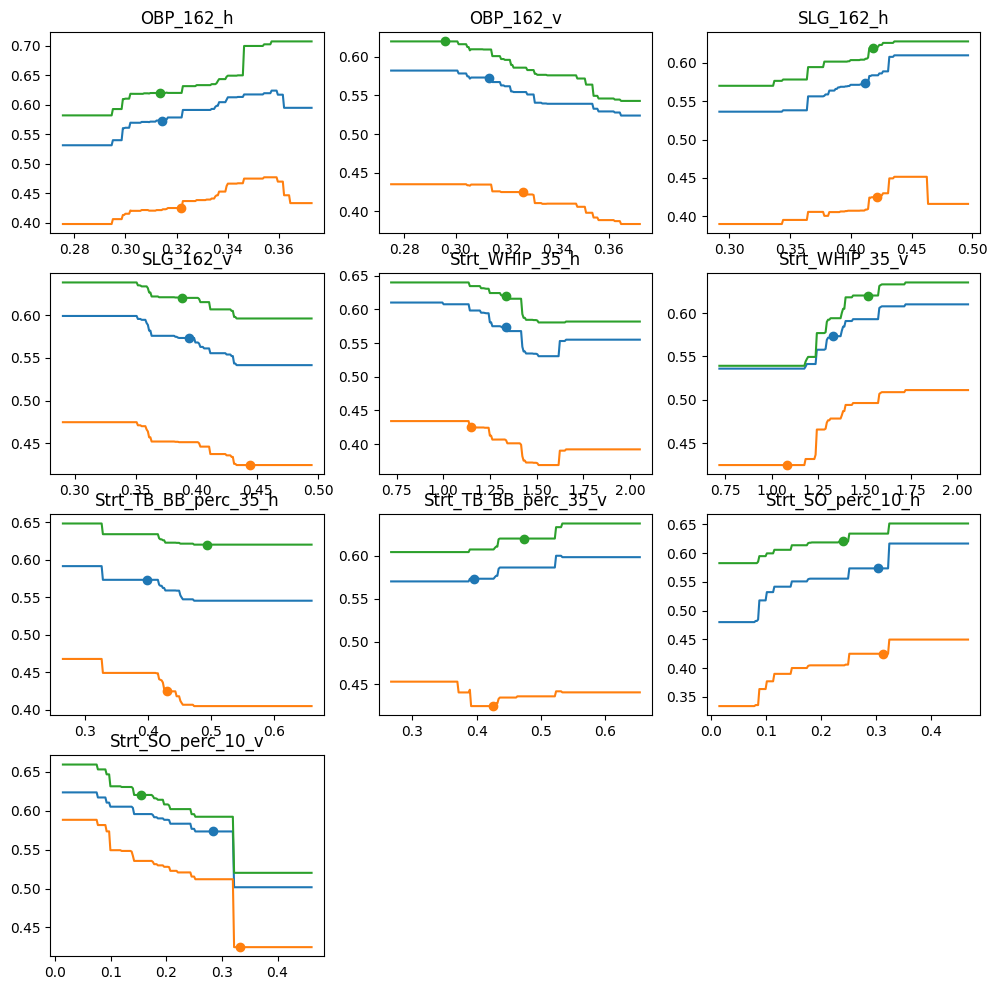

In [49]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

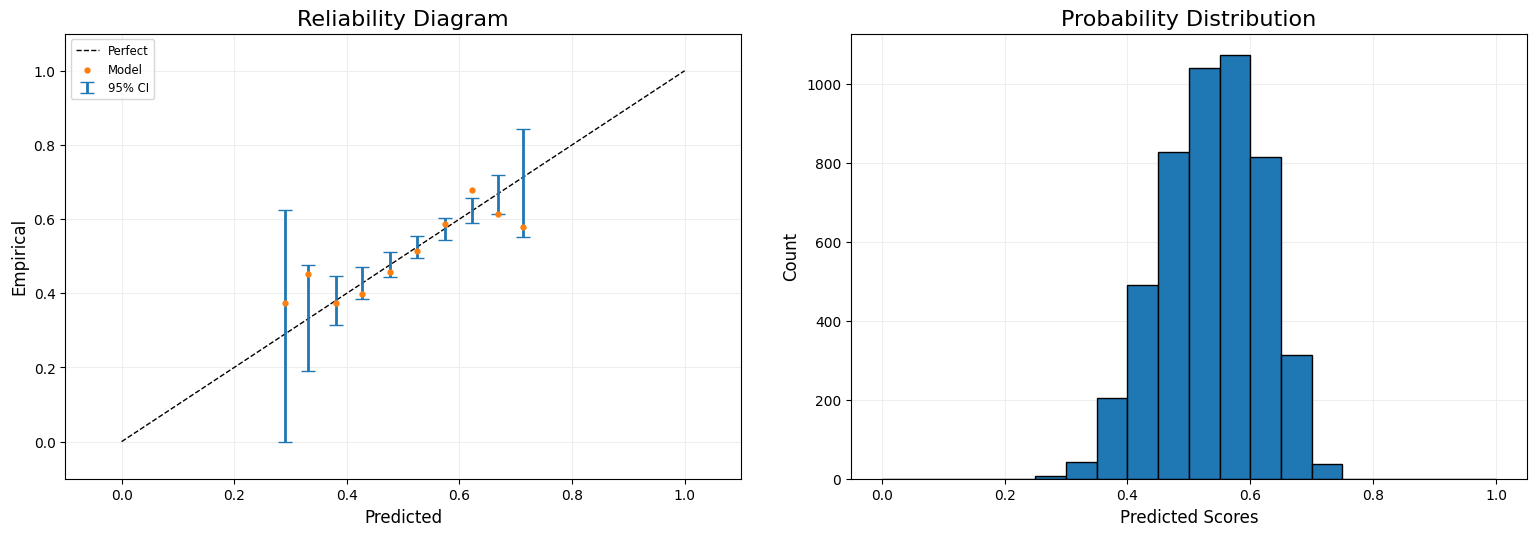

In [50]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [51]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [52]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.161727
Strt_SO_perc_10_v       0.096255
Strt_WHIP_35_v          0.093154
Strt_SO_perc_10_h       0.091718
Strt_WHIP_35_h          0.086672
OBP_162_h               0.078657
OBP_162_v               0.077400
SLG_162_h               0.049080
SLG_162_v               0.044955
Strt_TB_BB_perc_35_h    0.037118
Strt_TB_BB_perc_35_v    0.026752
dtype: float64

How much do these differences in log loss really mean?

When model A does a few bps better than model B in log loss, how should we think about that?

Is it a meaningful improvement?
How do we know it is not just "luck of the draw" of the test set
We'll run some quick simulations to build our intuition about this.

In [53]:
# Simulate a test set (with given "true" probabilities) and compare two models, 
def ll_dist(probvec_true, probvec_mod1, probvec_mod2, num_trials):
    llvec_mod1 = np.zeros(num_trials)
    llvec_mod2 = np.zeros(num_trials)
    for i in range(num_trials):
        sim_outcome = np.random.binomial(n=1, p=probvec_true)
        llvec_mod1[i] = log_loss(sim_outcome, probvec_mod1)
        llvec_mod2[i] = log_loss(sim_outcome, probvec_mod2)
    return(llvec_mod1 - llvec_mod2)

In [54]:
pv_true = df_test.implied_prob_h_mid
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.04, .04, len(pv_true))

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)

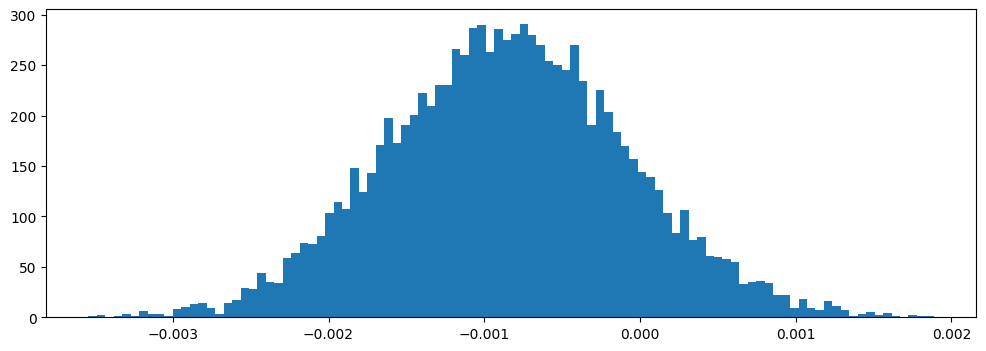

In [55]:
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

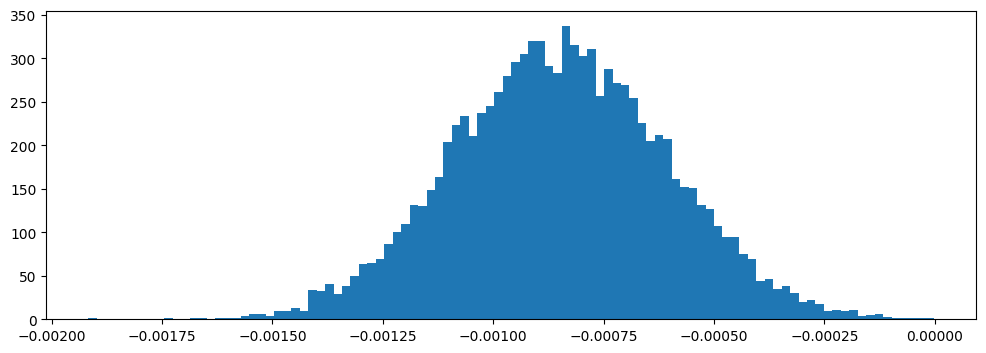

In [56]:
pv_true = np.repeat(df_test.implied_prob_h_mid,10)
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.04, .04, len(pv_true))

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

In [57]:
pv_true = df_test.implied_prob_h_mid
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.10, .10, len(pv_true))

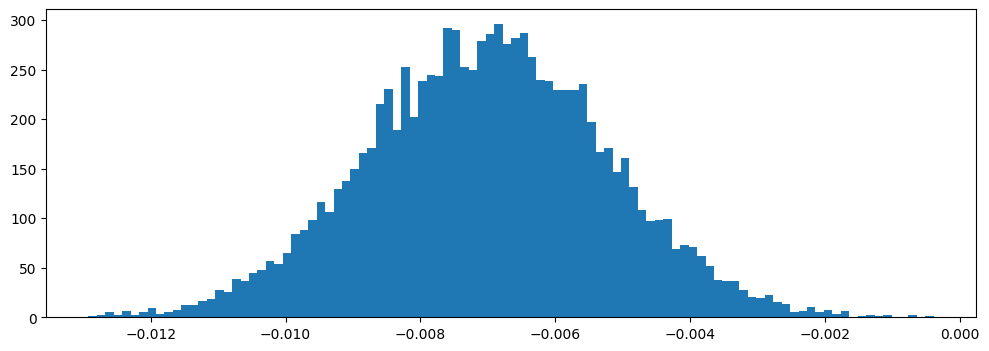

In [58]:

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

Conclusions

    - Could be that 5-10 bps improvement is meaningful!
    - Variation due to test set size is considerable
    - Not a simple matter to increase test set size in this problem
    - For now, still need to improve beyond minor optimizations


Potential Next Steps??

    - Have nothing about the quality of the bullpen
    - Bullpen is more meaningful in recent years, as starting pitchers work fewer innings
    - Could cause an issue with "model drift" (something to explore later on)
    - We don't account for the specific hitting lineup (would need individual batter data)
    - We have nothing about fielding
    - Several additional sources of model drift
    - Rule changes about infield positioning
    - Pitching clock
    - NL now has a DH